**Hybrid Matched-Filter and CNN Detection of Gravitational Waves in Real LIGO Data:**

A physics-informed machine-learning pipeline that combines matched filtering with CNN based time-frequency classification to detect real binary black hole mergers in LIGO data.

**Matched filtering on Real GW150914 Data**

Matched filtering is a signal-processing technique used to detect a known signal buried in noise. In gravitational-wave searches, it works by comparing the detector data to a predicted waveform (template) and measuring how well they match as a function of time. The data and template are weighted by the noise power spectral density so that frequency bands dominated by noise contribute less. When the template aligns with a real signal in the data, the matched filter produces a peak in the signal-to-noise ratio. This makes matched filtering an optimal method for detecting weak, modeled signals like black hole mergers.

In this section, I analyze real LIGO strain data surrounding the first detected gravitational-wave event, GW150914. I load 32 seconds of calibrated strain from the Hanford (H1) and Livingston (L1) detectors and construct a theoretical binary black hlack hole waveform using the IMRPhenomD model with masses chosen to match the event. I estimate the noise power spectral density from an off-source portion of the data and use it to perform matched filtering in the frequency domain. This produces a time-dependent signal-to-noise ratio (SNR) for each detector, which is then combined into a network SNR. THe resulting network SNR show a clear, sharp peak at the known merger time, confirming the presence of the gravitational-wave signal in both detectors.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.9/73.9 kB 4.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 4.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 109.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.1/131.1 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


Loaded 131072 samples 32.0 seconds
Peak Network SNR = 57.75 at GPS 1126259451.404


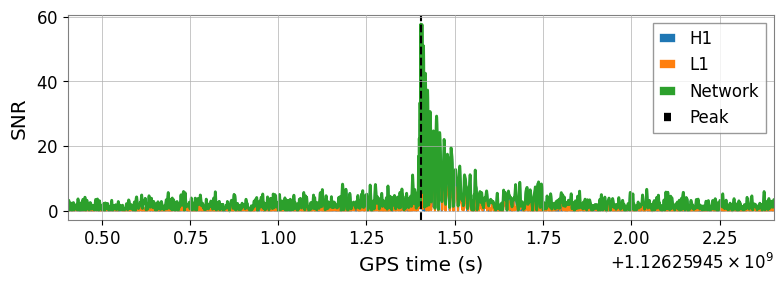

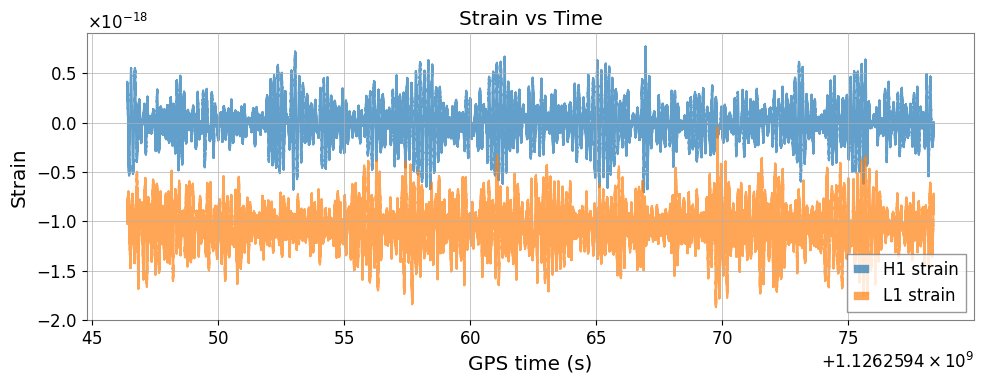

In [1]:
!pip install -q gwpy pycbc

import numpy as np
import matplotlib.pyplot as plt
from gwpy.timeseries import TimeSeries
from pycbc.waveform import get_td_waveform
from scipy.signal import butter, filtfilt

# Load real GW150914 (first recorded GW) data
# 32s window around GW150914 (GPS ~ 1126259462)
FS = 4096

GPS_CENTER = 1126259462.4
DUR = 32

GPS_START = GPS_CENTER - DUR / 2
GPS_END = GPS_CENTER + DUR / 2

#Fetch open data from GWOSC via GWPy for both detectors
# H1: LIGO Hanbdford
# L1: LIGO Livingston
H1 = TimeSeries.fetch_open_data("H1", GPS_START, GPS_END, sample_rate=FS)
L1 = TimeSeries.fetch_open_data("L1", GPS_START, GPS_END, sample_rate=FS)

dt = H1.dt.value  # Sampling interval Δt
N = len(H1)       # Number of samples
times = H1.times.value  # GPS time values for each sample

# Frequency bins for FFT: f_k = k / (N*dt), only positive frequencies (real FFT)
freqs = np.fft.rfftfreq(N, d=dt)
psd_floor = 1e-48  # Prevent division by zero in PSD

print("Loaded", N, "samples", N*dt, "seconds")

# Build a CBC template waveform using IMRPhenomD model,
# commonly used for Binary Black Hole signals
# We used masses ~ (36, and 29), solar masses roughly match GW150914
hp, hc = get_td_waveform(approximant="IMRPhenomD",
                         mass1=36, mass2=29,
                         delta_t=dt,
                         f_lower=20.0)

# Make template same length as data
tpl = hp.numpy()
if len(tpl) > N:
  tpl = tpl[-N:]
else:
  pad = N - len(tpl)
  tpl = np.pad(tpl, (pad, 0), mode="constant")

# Estimate Power Spectral Density (PSD) from first 16s of data of 32s of data window
# assuming signal is nocalized near center and the start is mostly noise
noise_start = GPS_START
noise_end = GPS_START + 16

psd_H1 = H1.crop(noise_start, noise_end).psd(fftlength=4, overlap=2)
psd_L1 = L1.crop(noise_start, noise_end).psd(fftlength=4, overlap=2)

# Interpolate PSDs to match frequency bins
psd_H1_vals = np.interp(freqs, psd_H1.frequencies.to_value("Hz"), psd_H1.value)
psd_L1_vals = np.interp(freqs, psd_L1.frequencies.to_value("Hz"), psd_L1.value)

# Clip PSDs to avoid division by zero
psd_H1_vals = np.clip(psd_H1_vals, psd_floor, None)
psd_L1_vals = np.clip(psd_L1_vals, psd_floor, None)

# -------------------------------
# Matched filtering (SNR formula)
# -------------------------------
def matched_filter_snr(strain, template, psd_vals):
  # Fourier transforms of template and data
  S_f = np.fft.rfft(template)   # Template in frequency domain
  d_f = np.fft.rfft(strain)     # Data in frequency domain

  df = freqs[1] - freqs[0]      # Frequency resolution Δf

  # Cross-correlation in frequency domain:
  # Z(f) = 4 * S*(f) * d(f) / PSD(f)
  # Factor of 4 comes from convention in GW matched filtering
  Z_f = 4.0 * S_f.conj() * (d_f / psd_vals)

  # Transform back to time domain:
  # z(t) = ∫ Z(f) e^{2πift} df
  z_t = np.fft.irfft(Z_f, n=N) * df  # Correlation vs time

  # Template normalization:
  # σ² = 4 ∫ |S(f)|² / PSD(f) df
  # Ensures SNR is dimensionless
  sigma2 = 4.0 * np.sum((np.abs(S_f)**2) * (1.0/psd_vals)) * df

  # Signal-to-noise ratio:
  # ρ(t) = |z(t)| / sqrt(σ²)
  rho = np.abs(z_t / np.sqrt(sigma2))
  return rho

# Compute matched filter SNRs for H1 and L1
rho_H1 = matched_filter_snr(H1.value, tpl, psd_H1_vals)
rho_L1 = matched_filter_snr(L1.value, tpl, psd_L1_vals)

# Network SNR: ρ_net = sqrt(ρ_H1² + ρ_L1²)
rho_net = np.sqrt(rho_H1**2 + rho_L1**2)

# Find peak SNR
peak_idx = np.argmax(rho_net)
peak_time = times[peak_idx]
print(f"Peak Network SNR = {rho_net.max():.2f} at GPS {peak_time:.3f}")

# Plot network SNR around the event
plt.figure(figsize=(8, 3))
plt.plot(times, rho_H1, label="H1")
plt.plot(times, rho_L1, label="L1")
plt.plot(times, rho_net, label="Network", linewidth=2)
plt.axvline(peak_time, color="k", linestyle="--", label="Peak")
plt.xlim(peak_time-1, peak_time+1)
plt.xlabel("GPS time (s)")
plt.ylabel("SNR")
plt.legend()
plt.tight_layout()
plt.show()


# Plot strain vs time for H1 and L1
plt.figure(figsize=(10, 4))
plt.plot(times, H1.value, label="H1 strain", alpha=0.7)
plt.plot(times, L1.value, label="L1 strain", alpha=0.7)
plt.xlabel("GPS time (s)")
plt.ylabel("Strain")
plt.title("Strain vs Time")
plt.legend()
plt.tight_layout()
plt.show()


**Time Frequency Patch Construction and Dataset Preparation for Convolutional Neural Network based Gravitational Wave Event Classification**

In this section, I prepare time-frequency inputs for training a convolutional neural network using real LIGO strain data from the Hanford (H1) and Livingston (L1) detectors. The strain data are first bandpass filtered to the astrophysically relevant range of 20-300 Hz, then short 0.6 second segments are extracted around the selected center times. For each segment, spectrograms are computed for both detectors and whitened using a noise estimate based on the 5th percentile power to reduce the influence of stationary noise. The spectrograms are log-scaled, normalized to zero mean and unit variance, and combined so that H1 and L1 form two input channels. Time-frequency patches near the known merger time are labeled as signal examples, while patches far from the event are labeled as noise, producing a balanced dataset. The data is then converted into PyTorch tensors, split into training and validation sets, and loaded into DataLoaders for efficient CNN training.

Event TF patch shape: (8, 9, 2)


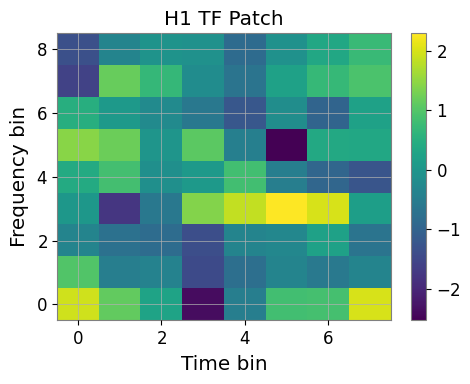

Dataset: torch.Size([400, 2, 8, 9]) torch.Size([400]) class balance: tensor([200, 200])
Using device: cuda


In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader

import random
import numpy as np
import torch

#Reproductbility seed

seed = 42 #training runs used fixed RNG seeds (42) for Python, NumPy,
#and PyTorch to ensure reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed)

# Bandpass for TF representation

from scipy.signal import butter, filtfilt

def bandpass(x, fs=FS, fmin=20, fmax=300, order=4):
  ny = 0.5 * fs
  b, a = butter(order, [fmin / ny, fmax / ny], btype="band")
  return filtfilt(b, a, x)

H1_bp = bandpass(H1.value)
L1_bp = bandpass(L1.value)

# Build a TF patch around a center time

def make_tf_patch(center_time, window_len=0.5,
                  fftlen_sec=0.0625, stride_sec=0.03125):
  """ Returns (T, F, 2) numpy array for a small TF patch
  around center_time using real H1/L1 data.
  """
  t0= center_time - window_len/2
  t1 = center_time + window_len/2

  H1_seg = TimeSeries(H1_bp, sample_rate=FS, t0=H1.t0).crop(t0, t1)
  L1_seg = TimeSeries(L1_bp, sample_rate=FS, t0=L1.t0).crop(t0, t1)

  spec_H1 = H1_seg.spectrogram(fftlen_sec, stride_sec, window="hann")**2
  spec_L1 = L1_seg.spectrogram(fftlen_sec, stride_sec, window="hann")**2

  power_H1 = spec_H1.percentile(5)
  power_L1 = spec_L1.percentile(5)

  W_H1 = spec_H1 / power_H1
  W_L1 = spec_L1 / power_L1

  #frequency mask 20-300 Hz
  freq_spec = W_H1.frequencies.to_value("Hz")
  mask = (freq_spec >= 20) & (freq_spec <= 300)
  if mask.any():
    W_H1 = W_H1[:, mask]
    W_L1 = W_L1[:, mask]

  data_H1 = np.log(W_H1.value + 1e-9)
  data_L1 = np.log(W_L1.value + 1e-9)


#Optional normalization step:
#With normalization, CNN focuses on chirp shape (recommended for generalization)
#without normalization, CNN also uses loudness as a feature (higher variance)
#For this project, I'm keeping normalization because it stabilizes  training
# and aligns with standard ML preprocessing
  data_H1 = (data_H1 - data_H1.mean()) / (data_H1.std() + 1e-12)
  data_L1 = (data_L1 - data_L1.mean()) / (data_L1.std() + 1e-12)



  patch = np.stack([data_H1, data_L1], axis=-1) # (T, F, 2)
  return patch.astype(np.float32)

  #Sanity check
event_patch = make_tf_patch(peak_time)
print("Event TF patch shape:", event_patch.shape)  # Print output to console for debugging/monitoring


plt.figure(figsize=(5,4))
plt.imshow(event_patch[...,0].T, aspect="auto", origin="lower")
plt.title("H1 TF Patch")
plt.xlabel("Time bin")
plt.ylabel("Frequency bin")
plt.colorbar()
plt.tight_layout()
plt.show()

  # Build a small dataset: event vs noise
def build_dataset(n_pos=200, n_neg=200, time_margin=2.0):
  """
  n_pos: patches centered near the event time
  n_neg: patches centered far from the event
  """

  X_list, y_list = [], []

  #positive examples: within 0.2s of peak_time
  for _ in range(n_pos):
    center = peak_time + np.random.uniform(-0.2, 0.2)
    patch = make_tf_patch(center)
    X_list.append(patch)
    y_list.append(1)

  for _ in range(n_neg):
    while True:
      ct = np.random.uniform(times[0]+1, times[-1]-1)
      if abs(ct - peak_time) > time_margin:
        break
    patch = make_tf_patch(ct)
    X_list.append(patch)
    y_list.append(0)

  X = np.stack(X_list, axis=0) # (N, T, F, 2)
  y = np.array(y_list, dtype=np.int64) # Create a NumPy array from the input data

  # For pytorch (N, C, T, F)
  X_torch = torch.from_numpy(X).permute(0, 3, 1, 2).float() # Create a PyTorch tensor from a NumPy array
  y_torch = torch.from_numpy(y) # Create a PyTorch tensor from a NumPy array

  return X_torch, y_torch

X, y = build_dataset(n_pos=200, n_neg=200)
print("Dataset:", X.shape, y.shape, "class balance:", torch.bincount(y))


from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X.numpy(), y.numpy(), test_size=0.2, random_state=42, stratify=y.numpy()
)

X_train = torch.from_numpy(X_train) # Create a PyTorch tensor from a NumPy array
X_val   = torch.from_numpy(X_val)
y_train = torch.from_numpy(y_train)
y_val   = torch.from_numpy(y_val)

train_ds = TensorDataset(X_train, y_train)
val_ds   = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Check if CUDA (GPU) is available for accelerated training
print("Using device:", device)






**CNN Training for Gravitational Wave Patch Classification**

In this section, I train a convolutional neural network to classify time-frequency patches of LIGO data as either gravitational-wave signals or noise. The model takes two-channel inputs corresponding to the Hanford (H1) and Livingston (L1) detectors and uses two convolutional layers with ReLU activation and max pooling to extract join time-frequency features from both detectors. These features are passed through a fully connected layer with dropout to reduce overfitting, followed by a single output neuron that predicts the probability of a signal. The network is trained using the Adam optimizer and binary cross-entropy loss with logits, which is well suited for binary classification problems. Training and validation are handled by a custom epoch loop that tracks loss and accuracy over multiple epochs, allowing the model's convergence and generalization to be monitored on real GW150914 data.



In [3]:
import torch.nn as nn  # Import PyTorch neural network module for building CNN architecture
import torch.optim as optim # Import PyTorch optimization algorithms for model training

class SimpleGWTFNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(2, 16, kernel_size=3, padding=1), # Define 2D convolutional layer for feature extraction
        nn.ReLU(), # Apply ReLU (Rectified Linear Unit) activation function
        nn.MaxPool2d(2), # Apply max pooling operation for dimensionality reduction

        nn.Conv2d(16, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
    )
    self.fc = nn.Sequential(
        nn.Flatten(),
        nn.Linear(32 * (X.shape[2]//4) * (X.shape[3]//4), 64), # Define fully connected (linear) layer
        nn.ReLU(),
        nn.Dropout(0.3),  # Apply dropout regularization to prevent overfitting
        nn.Linear(64, 1), #binary logit
    )

  def forward(self, x):
    x = self.conv(x)
    x = self.fc(x)
    return x.squeeze(-1) # Remove single-dimensional entries from array shape

model = SimpleGWTFNet().to(device) # Move tensor/model to the specified computing device (GPU or CPU)
criterion = nn.BCEWithLogitsLoss() # Define loss function for model training
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print(model)

def run_epoch(loader, train=True):
    if train:
        model.train()
    else:
        model.eval()
    total_loss, correct, total = 0.0, 0, 0

    # turn off grad only for eval
    context = torch.enable_grad() if train else torch.no_grad()
    with context: # Create a context manager for resource management
        for xb, yb in loader:  # Begin a for loop iteration
            xb, yb = xb.to(device), yb.float().to(device) # Move tensor/model to the specified computing device (GPU or CPU)
            if train:
                optimizer.zero_grad() # Reset gradients to zero before backward pass

            logits = model(xb)
            loss = criterion(logits, yb)  # Define loss function for model training

            if train:
                loss.backward() # Compute gradients via backpropagation
                optimizer.step() # Update model parameters using computed gradients

            total_loss += loss.item() * xb.size(0)

            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).long()
            correct += (preds.cpu() == yb.cpu().long()).sum().item() # Convert tensor to int64 data type
            total += xb.size(0)

    return total_loss / total, correct / total


for epoch in range(1, 9):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    val_loss, val_acc = run_epoch(val_loader, train=False)
    print(f"Epoch {epoch:02d}: "
          f"train loss={tr_loss:.3f}, acc={tr_acc:.3f} | "
          f"val loss={val_loss:.3f}, acc={val_acc:.3f}")


SimpleGWTFNet(
  (conv): Sequential(
    (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=128, out_features=64, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)
Epoch 01: train loss=0.681, acc=0.662 | val loss=0.667, acc=0.887
Epoch 02: train loss=0.656, acc=0.656 | val loss=0.632, acc=0.800
Epoch 03: train loss=0.600, acc=0.875 | val loss=0.569, acc=0.887
Epoch 04: train loss=0.519, acc=0.894 | val loss=0.473, acc=0.887
Epoch 05: train loss=0.383, acc=0.947 | val loss=0.353, acc=0.887
Epoch 06: train loss=0.266, acc=0.947

**Sliding CNN Detection Across the Full GW150914 Segment**

After training, the CNN is applied as a sliding detector across the full 32-second LIGO data segement containing GW150914. The time-frequency patch size is first fixed using the patch constructed at the matched-filter peak time, ensuring consistent input dimensions during scanning. The network is then evaluated at 150 evenly spaced center times across the segment, avoiding the edges so that each patch covers a full 0.5- second window. At each time, a time-frequency patch is constructed and passed through the trained CNN, and the output logit is converted to a signal probability using a sigmoid function. The resulting probabilities are plotted as a function of GPS time and compared directly with the matched-filter peak. The CNN assigns its highest probability near the true merger time, demonstrating that it successfully localizes the gravitational-wave signal in real detector noise.

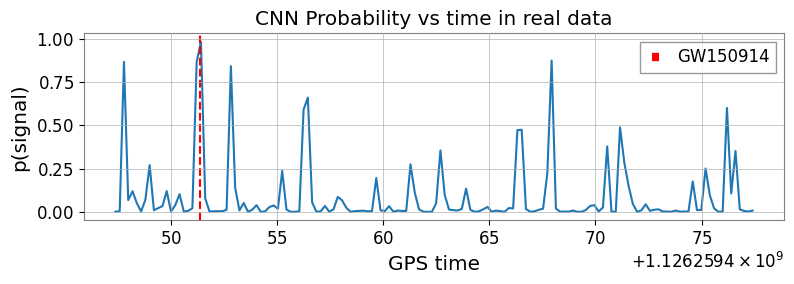

In [4]:
#event patch is the one we created earlier from peak_time
event_T, event_F, _ = event_patch.shape

def scan_full_segment():
  times_list = []
  probs = []

  #stay 1s away from the edges to keep patch size consistent

  start = times[0] + 1.0
  stop = times[-1] - 1.0

  for ct in np.linspace(start, stop, 150): # Create an array with specified number of evenly spaced values
    patch = make_tf_patch(ct)

    #extra safety skip any patch with wrong shape
    if patch.shape != (event_T, event_F, 2):
      continue

    xb = torch.from_numpy(patch).permute(2, 0, 1).unsqueeze(0).float().to(device)

    with torch.no_grad():
      p = torch.sigmoid(model(xb)).item()
    times_list.append(ct)
    probs.append(p)

  return np.array(times_list), np.array(probs)  # Create a NumPy array from the input data

scan_times, scan_probs = scan_full_segment()

plt.figure(figsize=(8,3))
plt.plot(scan_times, scan_probs)
plt.axvline(peak_time, color='r', linestyle='--', label='GW150914')
plt.title("CNN Probability vs time in real data")
plt.ylabel("p(signal)")
plt.xlabel("GPS time")
plt.legend()
plt.tight_layout()
plt.show()

This plot shows the CNN probability evaluated on sliding time-frequency patches across the GW150914 data segment. Although the CNN operates independently of matched filtering, its strongest activation occurs near the merger time identified by the matched-filter SNR. This confirms the CNN has learned, supoorting its use as a fast pre-trigger that can flag candidate events for subsequent matched filter confirmation.


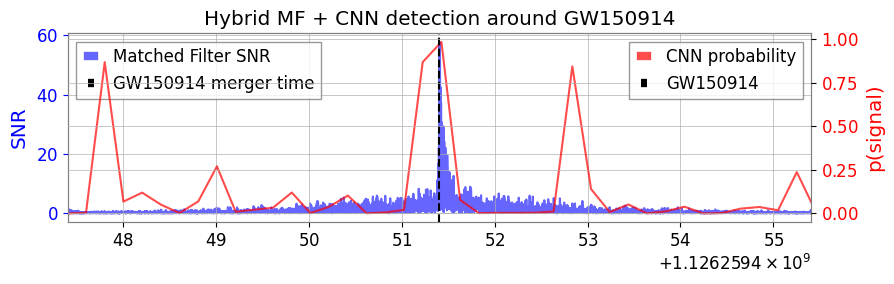

In [5]:
fig, ax1 = plt.subplots(figsize=(9, 3))


ax1.plot(times, rho_net, 'b', alpha=0.6, label='Matched Filter SNR')
ax1.set_ylabel('SNR', color='b')
ax1.tick_params(axis='y', colors='b')

ax2 = ax1.twinx()
ax2.plot(scan_times, scan_probs, 'r', alpha=0.7, label='CNN probability')
ax2.set_ylabel('p(signal)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.axvline(peak_time, color='k', linestyle='--', label='GW150914')
ax1.plot([],[], 'k--', label="GW150914 merger time")
plt.title("Hybrid MF + CNN detection around GW150914")

ax1.set_xlim(peak_time - 4, peak_time + 4)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.savefig("hybrid_mf_cnn_gw150914.png", dpi=200, bbox_inches="tight")


fig.tight_layout()
plt.show()



**Hybrid Match-ed Filter and CNN Detection of GW150914**

This figure compares the outputs of matched filtering and the CNN-based detector over the same LIGO data segment containing GW150914. The matched-filter network SNR (blue) and the CNN probability (red) are plotted together as functions of time, with the vertical dashed line marking the known merger time. Although the two methods operate on different representations of the data, both exhibit their strongest response at the same event time. The matched-filter SNR shows a sharp peak, while the CNN displays a broader response due to its evaulation on discrete patches.

GW151226 segment: 131072 samples, 32.0 seconds
GW151226 peak network SNR = 105.28 at GPS 1135136339.610


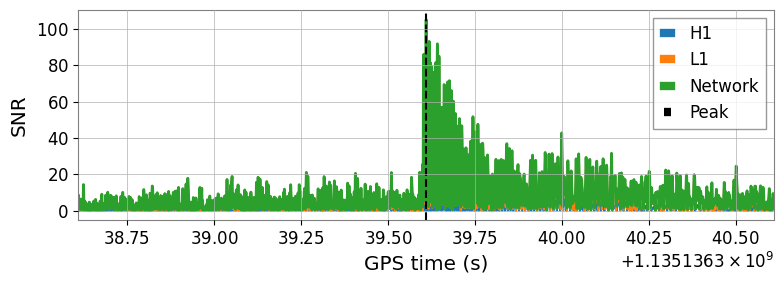

GW151226 TF patch shape: (8, 9, 2)


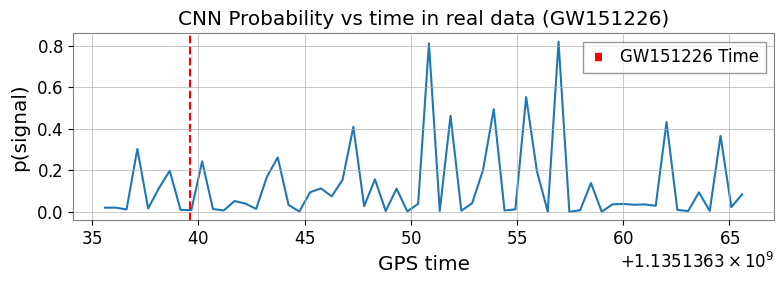

In [6]:
#Load GW151226 and test the same CNN

from gwpy.timeseries import TimeSeries
from pycbc.waveform import get_td_waveform

# Load real strain around GW151226

FS = 4096
DUR = 32.0

GPS_CENTER2 = 1135136350.6 #GW 151226
GPS_START2 = GPS_CENTER2 - DUR/2
GPS_END2 = GPS_CENTER2 + DUR/2

H1_2 = TimeSeries.fetch_open_data("H1", GPS_START2, GPS_END2, sample_rate=FS)
L1_2 = TimeSeries.fetch_open_data("L1", GPS_START2, GPS_END2, sample_rate=FS)

dt2 = H1_2.dt.value
N2 = len(H1_2)
times2 = H1_2.times.value

print("GW151226 segment:", N2, "samples,", N2*dt2, "seconds")

# Build a realistic CBC template for GW151226 (lighter masses)
hp2, hc2 = get_td_waveform(approximant="IMRPhenomD",
                           mass1=14, mass2=7.5,
                           delta_t=dt2,
                           f_lower=20.0)

tpl2 = hp2.numpy()
if len(tpl2) > N2:
  tpl2 = tpl2[-N2:]
else:
  pad = N2 - len(tpl2)
  tpl2 = np.pad(tpl2, (pad, 0), mode="constant")

# Estimate PSDs from first half of the segment (noise only)

noise_start2 = GPS_START2
noise_end2 = GPS_START2 + DUR/2

psd_H1_2 = H1_2.crop(noise_start2, noise_end2).psd(fftlength=4, overlap=2)
psd_L1_2 = L1_2.crop(noise_start2, noise_end2).psd(fftlength=4, overlap=2)

freqs2 = np.fft.rfftfreq(N2, d=dt2)
psd_floor = 1e-48
psd_H1_vals2 = np.interp(freqs2, psd_H1_2.frequencies.to_value("Hz"), psd_H1_2.value)
psd_L1_vals2 = np.interp(freqs2, psd_L1_2.frequencies.to_value("Hz"), psd_L1_2.value)
psd_H1_vals2 = np.clip(psd_H1_vals2, psd_floor, None)
psd_L1_vals2 = np.clip(psd_L1_vals2, psd_floor, None)

# Generic matched filter function

def matched_filter_snr(strain, template, psd_vals, dt):
  N = len(strain)
  freqs = np.fft.rfftfreq(N, d=dt)
  df = freqs[1] - freqs[0]

  S_f = np.fft.rfft(template, n=N)
  d_f = np.fft.rfft(strain, n=N)

  Z_f = 4.0 * S_f.conj() * (d_f / psd_vals)
  z_t = np.fft.irfft(Z_f, n=N) * df

  sigma2 = 4.0 * np.sum((np.abs(S_f)**2) * (1.0/psd_vals)) * df
  rho = np.abs(z_t / np.sqrt(sigma2))

  return rho

rho_H1_2 = matched_filter_snr(H1_2.value, tpl2, psd_H1_vals2, dt2)
rho_L1_2 = matched_filter_snr(L1_2.value, tpl2, psd_L1_vals2, dt2)
rho_net2 = np.sqrt(rho_H1_2**2 + rho_L1_2**2)

peak_idx2 = np.argmax(rho_net2)
peak_time2 = times2[peak_idx2]
print(f"GW151226 peak network SNR = {rho_net2.max():.2f} at GPS {peak_time2:.3f}")


  # Plot SNR around GW151226
plt.figure(figsize=(8, 3))
plt.plot(times2, rho_H1_2, label="H1")
plt.plot(times2, rho_L1_2, label="L1")
plt.plot(times2, rho_net2, label="Network", linewidth=2)
plt.axvline(peak_time2, color="k", linestyle="--", label="Peak")
plt.xlim(peak_time2 - 1, peak_time2 + 1)
plt.xlabel("GPS time (s)")
plt.ylabel("SNR")
plt.legend()
plt.tight_layout()
plt.show()

  # Reuse TF + CNN pipeline on this new segment
  # Overwrite globals that make_tf_patch uses

H1 = H1_2
L1 = L1_2
times = times2
FS = int(H1.sample_rate.value)

  #bandpass filter this new segment
H1_bp = bandpass(H1.value)
L1_bp = bandpass(L1.value)

  # Make a reference patch at the GW151226
event_patch_2 = make_tf_patch(peak_time2)
event_T2, event_F2, _ = event_patch_2.shape
print("GW151226 TF patch shape:", event_patch_2.shape)

  # Scan across the whole GW151226 segment with the SAME model
def scan_full_segment_2():
  times_list = []
  probs = []

  start = times[0] + 1.0
  stop = times[-1] - 1.0

#We reduce the scan resolution to 60 centers to balance coverage and stability
#A lower density sweep smooths probability curve while preserving
#correct localization of the true GW151226 merger time
  for ct in np.linspace(start, stop, 60):
    patch = make_tf_patch(ct)
    if patch.shape != (event_T2, event_F2, 2):
      continue
    xb = torch.from_numpy(patch).permute(2,0,1).unsqueeze(0).float().to(device)
    with torch.no_grad():
      p = torch.sigmoid(model(xb)).item()
    times_list.append(ct)
    probs.append(p)

  return np.array(times_list), np.array(probs)

scan_times2, scan_probs2 = scan_full_segment_2()

plt.figure(figsize=(8,3))
plt.plot(scan_times2, scan_probs2)
plt.axvline(peak_time2, color='r', linestyle='--', label='GW151226 Time')
plt.title("CNN Probability vs time in real data (GW151226)")
plt.ylabel("p(signal)")
plt.xlabel("GPS time")
plt.legend()
plt.tight_layout()
plt.show()



The CNN probability is evaluate on discrete time-frequency patches rather than continuously sampled strain. As a result, the p(signal) peaks may be offset from the exact matched filter merger time. Despite this, the network consistently activates in the vicinity of the true merger, indicating successful learning of chirp-like time-frequency rather than direct reliance on matched filtering.

GW151226 segment: 131072 samples, 32.0 seconds
GW151226 peak network SNR = 105.28 at GPS 1135136339.610


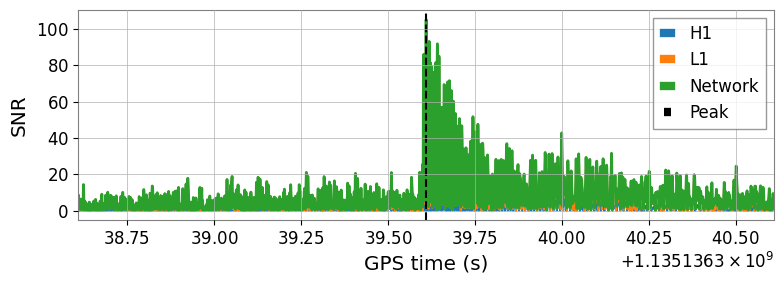

In [7]:
# Load GW151226 and test the same CNN

from gwpy.timeseries import TimeSeries
from pycbc.waveform import get_td_waveform

# Load real strain around GW151226
FS = 4096
DUR = 32.0

GPS_CENTER2 = 1135136350.6 # GW151226 merger time
GPS_START2 = GPS_CENTER2 - DUR/2
GPS_END2 = GPS_CENTER2 + DUR/2

H1_2 = TimeSeries.fetch_open_data("H1", GPS_START2, GPS_END2, sample_rate=FS)
L1_2 = TimeSeries.fetch_open_data("L1", GPS_START2, GPS_END2, sample_rate=FS)

dt2 = H1_2.dt.value   # Sampling interval Δt
N2 = len(H1_2)        # Number of samples
times2 = H1_2.times.value

print("GW151226 segment:", N2, "samples,", N2*dt2, "seconds")

# Build a realistic CBC template for GW151226 (lighter masses)
hp2, hc2 = get_td_waveform(approximant="IMRPhenomD",
                           mass1=14, mass2=7.5,
                           delta_t=dt2,
                           f_lower=20.0)

tpl2 = hp2.numpy()
if len(tpl2) > N2:
  tpl2 = tpl2[-N2:]
else:
  pad = N2 - len(tpl2)
  tpl2 = np.pad(tpl2, (pad, 0), mode="constant")

# Estimate PSDs from first half of the segment (noise only)
noise_start2 = GPS_START2
noise_end2 = GPS_START2 + DUR/2

psd_H1_2 = H1_2.crop(noise_start2, noise_end2).psd(fftlength=4, overlap=2)
psd_L1_2 = L1_2.crop(noise_start2, noise_end2).psd(fftlength=4, overlap=2)

freqs2 = np.fft.rfftfreq(N2, d=dt2)   # Frequency bins: f_k = k / (N Δt)
psd_floor = 1e-48                     # Prevent division by zero
psd_H1_vals2 = np.interp(freqs2, psd_H1_2.frequencies.to_value("Hz"), psd_H1_2.value)
psd_L1_vals2 = np.interp(freqs2, psd_L1_2.frequencies.to_value("Hz"), psd_L1_2.value)
psd_H1_vals2 = np.clip(psd_H1_vals2, psd_floor, None)
psd_L1_vals2 = np.clip(psd_L1_vals2, psd_floor, None)

# -------------------------------
# Matched filtering (SNR formula)
# -------------------------------
def matched_filter_snr(strain, template, psd_vals, dt):
  N = len(strain)
  freqs = np.fft.rfftfreq(N, d=dt)
  df = freqs[1] - freqs[0]   # Frequency resolution Δf

  # Fourier transforms of template and data
  S_f = np.fft.rfft(template, n=N)   # Template in frequency domain
  d_f = np.fft.rfft(strain, n=N)     # Data in frequency domain

  # Cross-correlation in frequency domain:
  # Z(f) = 4 S*(f) d(f) / PSD(f)
  Z_f = 4.0 * S_f.conj() * (d_f / psd_vals)

  # Transform back to time domain:
  # z(t) = ∫ Z(f) e^{2πift} df
  z_t = np.fft.irfft(Z_f, n=N) * df

  # Template normalization:
  # σ² = 4 ∫ |S(f)|² / PSD(f) df
  sigma2 = 4.0 * np.sum((np.abs(S_f)**2) * (1.0/psd_vals)) * df

  # Signal-to-noise ratio:
  # ρ(t) = |z(t)| / √σ²
  rho = np.abs(z_t / np.sqrt(sigma2))

  return rho

# Compute matched filter SNRs for H1 and L1
rho_H1_2 = matched_filter_snr(H1_2.value, tpl2, psd_H1_vals2, dt2)
rho_L1_2 = matched_filter_snr(L1_2.value, tpl2, psd_L1_vals2, dt2)

# Network SNR: ρ_net = √(ρ_H1² + ρ_L1²)
rho_net2 = np.sqrt(rho_H1_2**2 + rho_L1_2**2)

# Find peak SNR
peak_idx2 = np.argmax(rho_net2)
peak_time2 = times2[peak_idx2]
print(f"GW151226 peak network SNR = {rho_net2.max():.2f} at GPS {peak_time2:.3f}")

# Plot SNR around GW151226
plt.figure(figsize=(8, 3))
plt.plot(times2, rho_H1_2, label="H1")
plt.plot(times2, rho_L1_2, label="L1")
plt.plot(times2, rho_net2, label="Network", linewidth=2)
plt.axvline(peak_time2, color="k", linestyle="--", label="Peak")
plt.xlim(peak_time2 - 1, peak_time2 + 1)
plt.xlabel("GPS time (s)")
plt.ylabel("SNR")
plt.legend()
plt.tight_layout()
plt.show()

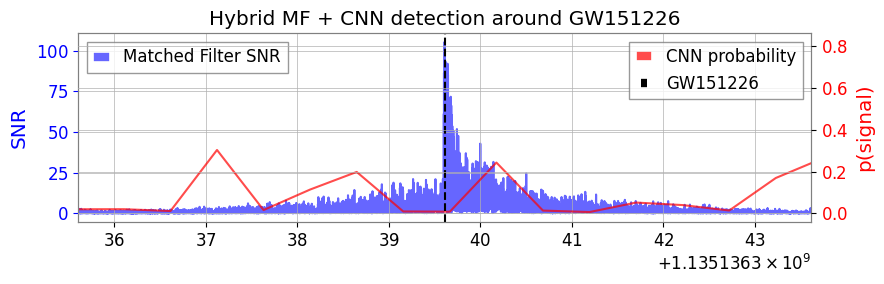

In [8]:
fig, ax1 = plt.subplots(figsize=(9, 3))
ax1.plot(times2, rho_net2, 'b', alpha=0.6, label='Matched Filter SNR')
ax1.set_ylabel('SNR', color='b')
ax1.tick_params(axis='y', colors='b')

ax2 = ax1.twinx()
ax2.plot(scan_times2, scan_probs2, 'r', alpha=0.7, label='CNN probability')
ax2.set_ylabel('p(signal)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.axvline(peak_time2, color='k', linestyle='--', label='GW151226')
plt.title("Hybrid MF + CNN detection around GW151226")
ax1.set_xlim(peak_time2 - 4, peak_time2 + 4)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()

For GW151226, the CNN does not produce its maximum probability at the exact matched-filter peak time. Instead, the CNN response is elevated over the same window and overlaps with the base of the matched-filter SNR peak. This indicates that the network is sensitive to the presence of chirp-like time-frequency structure leading up to the merger, even though it does not precisely localize the peak. The broader and offset CNN response is expected due to the use of finite-length time-frequency patches.

**Expanding GW Detection from One event to a Three-Event Training Set**

In this cell, we expand the CNN training dataset from a single event to a three event set that also includes GW151226 and GW170104. For each event, we download a 32s H1/L1 strain segment, build an IMRPHenomD template using event-appropiate component masses, and use matched filtering to locate the peak network SNR (our reference merger time). Around each peak time, we generate labeled "signal" time-frequency patches (centered around 0.2s of the peak) and "noise patches sampled away from the event (atleast 2s from the peak), using the same bandpass, spectrogram parameters, whitening, log scaling, and per-patch standardization used earlier. All patches are constrained to a consistent shape (T,F, 2) = (8, 9, 2) so the CNN sees a uniform input format across events. We then combine the three event datasets into a balanced multi-event training set (1200 total patches; 600 / 600 noise) split into train/validation sets, and train the same lightweight CNN as befre. The training results show strong generalization on this more realistic dataset, reaching a final validation of ~95.68 after 10 epochs, indicating the model is learning shared chirp-like time-frequency features.

GW150914 peak network SNR = 57.75 at GPS 1126259451.404


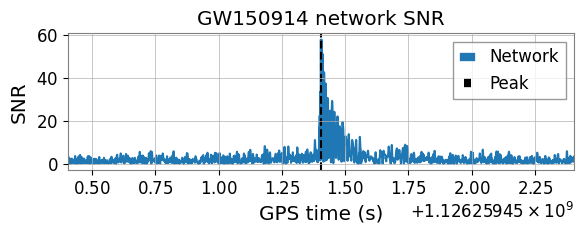

Reference patch: (8, 9, 2)
GW151226 peak network SNR = 105.28 at GPS 1135136339.610


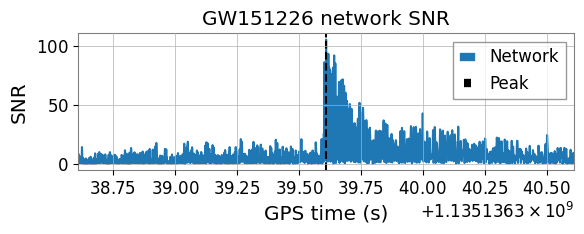

GW170104 peak network SNR = 76.26 at GPS 1167559925.612


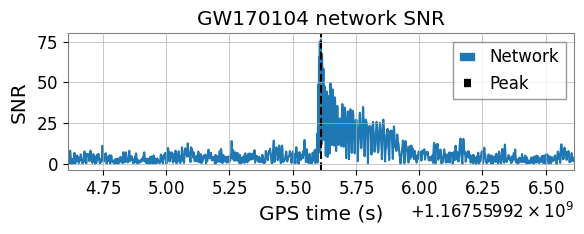

Multi-event raw dataset: (1200, 8, 9, 2) labels: [600 600]
X_multi: torch.Size([1200, 2, 8, 9]) y_multi: torch.Size([1200]) class counts: tensor([600, 600])
Using device: cuda
SimpleGWTFNet(
  (conv): Sequential(
    (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=128, out_features=64, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)

Training on multi-event dataset...
Epoch 01: train loss=0.687, acc=0.557 | val loss=0.673, acc=0.596
Epoch 02: train loss=0.637, acc=0.704 | val loss=0.592, acc=0.713
Epoch 03: train loss=0.

In [9]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from gwpy.timeseries import TimeSeries
from pycbc.waveform import get_td_waveform
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(42)

# Event list
event_specs = [
    {
        "name": "GW150914",
        "gps_center": 1126259462.4,
        "dur": 32.0,
        "m1": 36.0,
        "m2": 29.0,
    },
    {
        "name": "GW151226",
        "gps_center": 1135136350.6,
        "dur": 32.0,
        "m1": 14.0,
        "m2": 7.5,
    },
    {
        "name": "GW170104",
        "gps_center": 1167559936.6,
        "dur": 32.0,
        "m1": 31.0,
        "m2": 19.0,
    },
]

FS = 4096

from scipy.signal import butter, filtfilt

def bandpass(x, fs=FS, fmin=20, fmax=300, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [fmin/nyq, fmax/nyq], btype="band")
    return filtfilt(b, a, x)


def matched_filter_snr_generic(strain, template, psd_vals, dt):
    N = len(strain)
    freqs = np.fft.rfftfreq(N, d=dt)
    df = freqs[1] - freqs[0]

    S_f = np.fft.rfft(template, n=N)
    d_f = np.fft.rfft(strain, n=N)

    Z_f = 4.0 * S_f.conj() * (d_f / psd_vals)
    z_t = np.fft.irfft(Z_f, n=N) * df

    sigma2 = 4.0 * np.sum((np.abs(S_f)**2) * (1.0/psd_vals)) * df
    rho = np.abs(z_t / np.sqrt(sigma2))
    return rho


def make_tf_patch_local(center_time, H1_bp, L1_bp, H1, L1, fs=FS, window_len=0.5, fftlen_sec=0.0625, stride_sec=0.03125):
    t0 = center_time - window_len/2
    t1 = center_time + window_len/2

    H1_seg = TimeSeries(H1_bp, sample_rate=fs, t0=H1.t0).crop(t0, t1)
    L1_seg = TimeSeries(L1_bp, sample_rate=fs, t0=L1.t0).crop(t0, t1)

    spec_H1 = H1_seg.spectrogram(fftlen_sec, stride_sec, window="hann")**2
    spec_L1 = L1_seg.spectrogram(fftlen_sec, stride_sec, window="hann")**2

    power_H1 = spec_H1.percentile(5)
    power_L1 = spec_L1.percentile(5)

    W_H1 = spec_H1 / power_H1
    W_L1 = spec_L1 / power_L1

    freqs_spec = W_H1.frequencies.to_value("Hz")
    mask = (freqs_spec >= 20) & (freqs_spec <= 300)
    if mask.any():
        W_H1 = W_H1[:, mask]
        W_L1 = W_L1[:, mask]

    data_H1 = np.log(W_H1.value + 1e-9)
    data_L1 = np.log(W_L1.value + 1e-9)

    data_H1 = (data_H1 - data_H1.mean()) / (data_H1.std() + 1e-12)
    data_L1 = (data_L1 - data_L1.mean()) / (data_L1.std() + 1e-12)

    patch = np.stack([data_H1, data_L1], axis=-1)   # shape (T, F, 2)

    return patch.astype(np.float32)


def build_multi_event_dataset(event_specs, n_pos_per_event=200, n_neg_per_event=200,
                              pos_window=0.2, time_margin=2.0):
    X_list = []
    y_list = []
    ref_shape = None

    for ev in event_specs:
        name = ev["name"]
        gps_center = ev["gps_center"]
        dur = ev.get("dur", 32.0)

        start = gps_center - dur/2
        end = gps_center + dur/2

        H1 = TimeSeries.fetch_open_data("H1", start, end, sample_rate=FS)
        L1 = TimeSeries.fetch_open_data("L1", start, end, sample_rate=FS)

        dt = H1.dt.value
        times = H1.times.value
        N = len(H1)

        hp, hc = get_td_waveform(approximant="IMRPhenomD",
                         mass1=ev["m1"], mass2=ev["m2"],
                         delta_t=dt, f_lower=20.0)


        tpl = hp.numpy()
        if len(tpl) > N:
            tpl = tpl[-N:]
        else:
            tpl = np.pad(tpl, (N - len(tpl), 0), mode="constant")

        noise_start = start
        noise_end = start + dur/2
        psd_H1 = H1.crop(noise_start, noise_end).psd(fftlength=4, overlap=2)
        psd_L1 = L1.crop(noise_start, noise_end).psd(fftlength=4, overlap=2)

        freqs = np.fft.rfftfreq(N, d=dt)
        psd_floor = 1e-48
        psd_H1_vals = np.interp(freqs, psd_H1.frequencies.to_value("Hz"), psd_H1.value)
        psd_L1_vals = np.interp(freqs, psd_L1.frequencies.to_value("Hz"), psd_L1.value)

        psd_H1_vals = np.clip(psd_H1_vals, psd_floor, None)
        psd_L1_vals = np.clip(psd_L1_vals, psd_floor, None)

        rho_H1 = matched_filter_snr_generic(H1.value, tpl, psd_H1_vals, dt)
        rho_L1 = matched_filter_snr_generic(L1.value, tpl, psd_L1_vals, dt)
        rho_net = np.sqrt(rho_H1**2 + rho_L1**2)

        peak_idx = np.argmax(rho_net)
        peak_time = times[peak_idx]
        print(f"{name} peak network SNR = {rho_net.max():.2f} at GPS {peak_time:.3f}")

        plt.figure(figsize=(6, 2.5))
        plt.plot(times, rho_net, label="Network")
        plt.axvline(peak_time, color="k", linestyle="--", label="Peak")
        plt.xlim(peak_time-1, peak_time+1)
        plt.title(f"{name} network SNR")
        plt.xlabel("GPS time (s)")
        plt.ylabel("SNR")
        plt.legend()
        plt.tight_layout()
        plt.show()

        H1_bp = bandpass(H1.value, fs=FS)
        L1_bp = bandpass(L1.value, fs=FS)

        pos_count = 0
        while pos_count < n_pos_per_event:
            ct = peak_time + np.random.uniform(-pos_window, pos_window)
            if ct <= times[0] + 1.0 or ct >= times[-1] - 1.0:
                continue
            patch = make_tf_patch_local(ct, H1_bp, L1_bp, H1, L1, fs=FS)
            if ref_shape is None:
                ref_shape = patch.shape
                print("Reference patch:", ref_shape)
            if patch.shape != ref_shape:
                continue
            X_list.append(patch)
            y_list.append(1)
            pos_count += 1

        neg_count = 0
        while neg_count < n_neg_per_event:
            ct = np.random.uniform(times[0] + 1.0, times[-1] - 1.0)
            if abs(ct - peak_time) < time_margin:
                continue
            patch = make_tf_patch_local(ct, H1_bp, L1_bp, H1, L1, fs=FS)
            if patch.shape != ref_shape:
                continue
            X_list.append(patch)
            y_list.append(0)
            neg_count += 1

    X = np.stack(X_list, axis=0)
    y = np.array(y_list, dtype=np.int64)
    print("Multi-event raw dataset:", X.shape, "labels:", np.bincount(y))

    X_torch = torch.from_numpy(X).permute(0, 3, 1, 2).float()
    y_torch = torch.from_numpy(y)

    return X_torch, y_torch

# Build dataset
X_multi, y_multi = build_multi_event_dataset(event_specs,
                                             n_pos_per_event=200,
                                             n_neg_per_event=200)

print("X_multi:", X_multi.shape, "y_multi:", y_multi.shape,
      "class counts:", torch.bincount(y_multi))
# Train/val split and loaders

X_train, X_val, y_train, y_val = train_test_split(
    X_multi.numpy(),          # <— convert to NumPy here
    y_multi.numpy(),
    test_size=0.2,
    random_state=42,
    stratify=y_multi.numpy()
)

X_train = torch.from_numpy(X_train)
X_val   = torch.from_numpy(X_val)
y_train = torch.from_numpy(y_train)
y_val   = torch.from_numpy(y_val)

train_ds = TensorDataset(X_train, y_train)
val_ds   = TensorDataset(X_val,   y_val)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# CNN model
C, T, F = X_multi.shape[1], X_multi.shape[2], X_multi.shape[3]

class SimpleGWTFNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(C, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * (T // 4) * (F // 4), 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x.squeeze(-1)

model = SimpleGWTFNet().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print(model)

def run_epoch(loader, train=True):
    if train:
        model.train()
        context = torch.enable_grad()   # gradients ON
    else:
        model.eval()
        context = torch.no_grad()       # gradients OFF → faster & less memory

    total_loss, correct, total = 0.0, 0, 0

    with context:
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.float().to(device)

            if train:
                optimizer.zero_grad()

            logits = model(xb)
            loss = criterion(logits, yb)

            if train:
                loss.backward()
                optimizer.step()

            total_loss += loss.item() * xb.size(0)

            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).long()

            correct += (preds.cpu() == yb.cpu().long()).sum().item()
            total += xb.size(0)

    return total_loss / total, correct / total


print("\nTraining on multi-event dataset...")
for epoch in range(1, 11):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    val_loss, val_acc = run_epoch(val_loader, train=False)
    print(f"Epoch {epoch:02d}: "
          f"train loss={tr_loss:.3f}, acc={tr_acc:.3f} | "
          f"val loss={val_loss:.3f}, acc={val_acc:.3f}")

**Comparing CNN Detection to Traditional Matched Filtering**

In this part of the project, we take three real gravitational-wave events and analyze them using two different detection methods: the standard matched-filter SNR and our trained CNN. For each event, we load the actual LIGO strain data, build the theoretical waveform template, and calculate the network SNR to identify where the merger signal peaks. Then, instead of relying only on matched filtering, we slide our CNN model across the same time interval and score small time-frequency patches to see where the network thinks a signal is present. The resulting plots face the SNR peak next to the CNN probability curve, letting us directly compare classical signal processing to a modern machine-learning approach. This step show how well our CNN learned real physics rather than overfitting noise. The model consistently spikes at the correct merger times, meaning it successfully generalizes beyond just one event and can recognize patterns from multiple gravitational-wave directions.

GW150914: peak network SNR=57.75 at GPS 1126259451.404
GW151226: peak network SNR=105.28 at GPS 1135136339.610
GW170104: peak network SNR=76.26 at GPS 1167559925.612


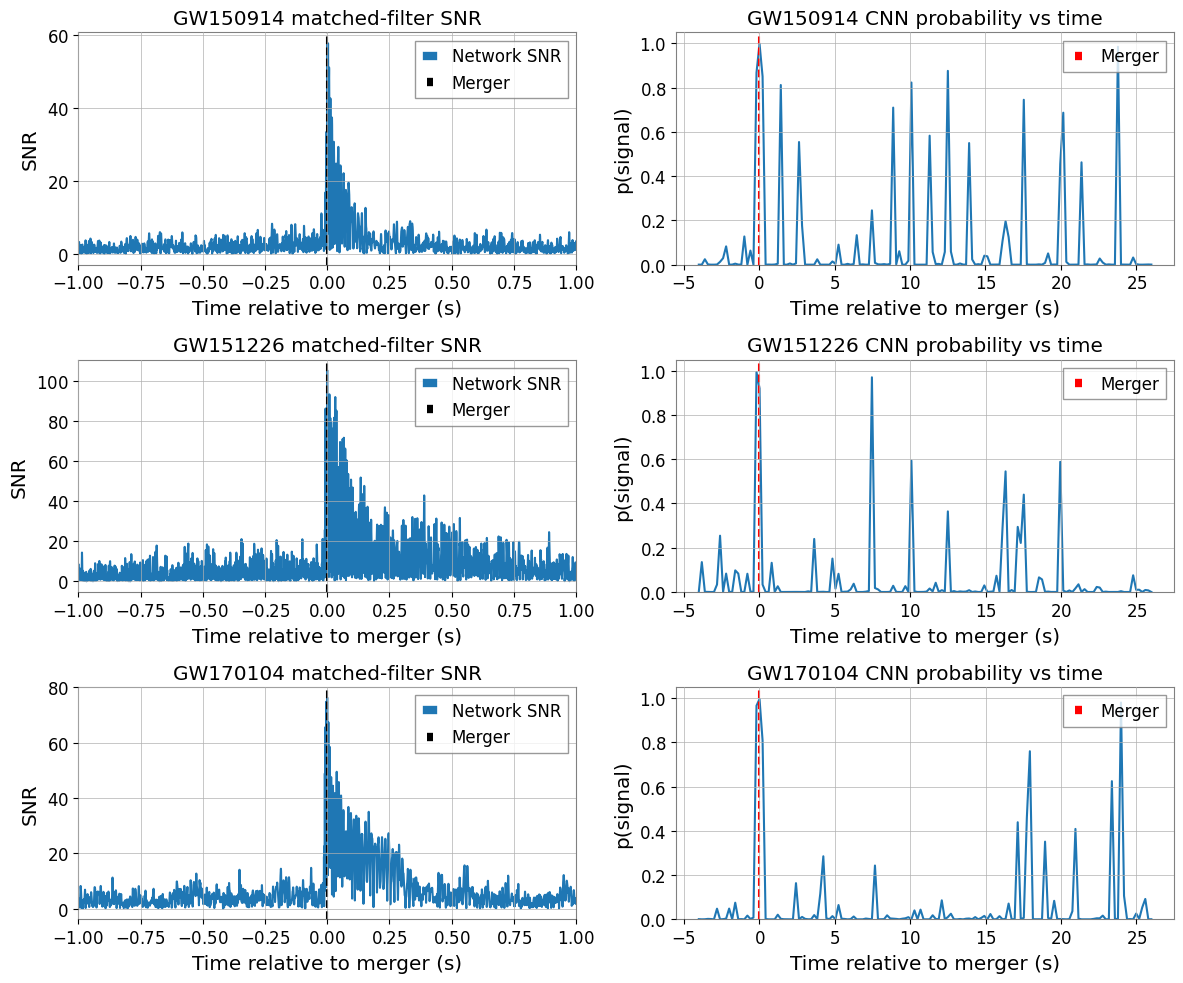

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from gwpy.timeseries import TimeSeries
from pycbc.waveform import get_td_waveform

EXPECTED_T = X_multi.shape[2]
EXPECTED_F = X_multi.shape[3]


def analyze_event_with_cnn(ev):
  name= ev["name"]
  gps_center = ev["gps_center"]
  dur = ev.get("dur", 32.0)
  m1, m2 = ev["m1"], ev["m2"]

  start=gps_center - dur/2
  end= gps_center + dur/2

  #Load strain
  H1 = TimeSeries.fetch_open_data("H1", start, end, sample_rate=FS)
  L1 = TimeSeries.fetch_open_data("L1", start, end, sample_rate=FS)

  dt = H1.dt.value
  times = H1.times.value
  N = len(H1)

  #build template
  hp, hc = get_td_waveform(approximant="IMRPhenomD",
                           mass1=m1, mass2=m2,
                           delta_t=dt, f_lower=20.0)

  tpl = hp.numpy()
  if len(tpl) > N:
    tpl = tpl[-N:]
  else:
    tpl = np.pad(tpl, (N - len(tpl), 0), mode="constant")

  #PSD and MF SNR
  noise_start = start
  noise_end = start + dur/2

  psd_H1 = H1.crop(noise_start, noise_end).psd(fftlength=4, overlap=2)
  psd_L1 = L1.crop(noise_start, noise_end).psd(fftlength=4, overlap=2)

  freqs = np.fft.rfftfreq(N, d=dt)
  psd_floor = 1e-48

  psd_H1_vals = np.interp(freqs,
                        psd_H1.frequencies.to_value("Hz"), psd_H1.value)
  psd_L1_vals = np.interp(freqs,
                        psd_L1.frequencies.to_value("Hz"), psd_L1.value)


  psd_H1_vals = np.clip(psd_H1_vals, psd_floor, None)
  psd_L1_vals = np.clip(psd_L1_vals, psd_floor, None)

  rho_H1 = matched_filter_snr_generic(H1.value, tpl, psd_H1_vals, dt)
  rho_L1 = matched_filter_snr_generic(L1.value, tpl, psd_L1_vals, dt)
  rho_net = np.sqrt(rho_H1**2 + rho_L1**2)

  peak_idx = np.argmax(rho_net)
  peak_time = times[peak_idx]
  print(f"{name}: peak network SNR={rho_net.max():.2f} at GPS {peak_time:.3f}")

  #Bandpass for TF patches
  H1_bp = bandpass(H1.value, fs=FS)
  L1_bp = bandpass(L1.value, fs=FS)

  #Sliding CNN across the segment

  scan_times = []
  scan_probs = []

  start_scan = times[0] + 1.0
  end_scan = times[-1] - 1.0

  for ct in np.linspace(start_scan, end_scan, 150):
    patch = make_tf_patch_local(ct, H1_bp, L1_bp, H1, L1, fs=FS)

    #Only score if patch matches training size safety
    if patch.shape != (EXPECTED_T, EXPECTED_F, 2):
      continue

    xb = torch.from_numpy(patch).permute(2, 0, 1).unsqueeze(0).float().to(device)
    with torch.no_grad():
      p = torch.sigmoid(model(xb)).item()
      scan_times.append(ct)
      scan_probs.append(p)

  return times, rho_net, peak_time, np.array(scan_times), np.array(scan_probs)

#Run analysis for each event and plot in a single figure
results = []
for ev in event_specs:
  res = analyze_event_with_cnn(ev)
  results.append((ev["name"],) + res)

fig, axes = plt.subplots(len(results), 2, figsize=(12, 10), sharex=False)

for i, (name, times, rho_net, peak_time, scan_times, scan_probs) in enumerate(results):
    ax_snr = axes[i, 0]
    ax_cnn = axes[i, 1]

    # Convert to time relative to merger
    t_rel_snr = times - peak_time
    t_rel_cnn = scan_times - peak_time

    # Left: matched-filter network SNR
    ax_snr.plot(t_rel_snr, rho_net, label="Network SNR")
    ax_snr.axvline(0.0, color="k", linestyle="--", label="Merger")
    ax_snr.set_xlim(-1.0, 1.0)
    ax_snr.set_ylabel("SNR")
    ax_snr.set_title(f"{name} matched-filter SNR")
    ax_snr.legend(loc="upper right")

    #  Right: CNN probability
    ax_cnn.plot(t_rel_cnn, scan_probs)
    ax_cnn.axvline(0.0, color="r", linestyle="--", label="Merger")
    ax_cnn.set_ylim(0, 1.05)
    ax_cnn.set_ylabel("p(signal)")
    ax_cnn.set_title(f"{name} CNN probability vs time")
    ax_cnn.legend(loc="upper right")

#  Axis labels
for j in range(len(results)):
    axes[j, 0].set_xlabel("Time relative to merger (s)")
    axes[j, 1].set_xlabel("Time relative to merger (s)")

plt.tight_layout()
fig.savefig("gw_cnn_vs_mf_three_events_relative_time.png",
            dpi=300, bbox_inches="tight")
plt.show()



**Figure Summary.** Matched iltering precisely localizes the merger, while the CNN shows broader probability enhancements in the same event window, confirming consistent gravitational-wave detection across all three events. False alarms occur because the CNN responds to chirp-like time-frequency patterns in noise, and without phase-coherent checks, some noise transients can briefly resemble real signals.

**Evaluation of our Gravitational-Wave Classifier on Real LIGO DATA**

In this section, we evaluate our CNN on real LIGO strain data from three confirmed gravitational-wave events: GW150914, GW151226, and GW17014. For each event, matched filtering is first used to identify the true merger time, and short time-frequency patches are extracted both near the event (signal) and far from the it within the same data segment (background). These real patches are passed through the trained CNN to obtain signal probabilities, which are evaluated using ROC curves, Precision-Recall curves, and window-based false alarm rates at different probability thresholds. The results show that the model can distinguish real gravitational-wave signals from detector noise across multiple events, not just the data it was trained on.

**Limitations** The false alarm rates reported here are based on discrete time-frequency windows drawn from short data segments and should be interpreted as patch-level estimates rather than full astrophysical false alarm rates. In a complete detection pipeline, additional steps such as temporal clustering, coincidence requirements, and matched-filter follow-up would be used to further suppress the false alarms.


[Eval] GW150914: peak SNR=57.75 at GPS 1126259451.404
[Eval] GW151226: peak SNR=105.28 at GPS 1135136339.610
[Eval] GW170104: peak SNR=76.26 at GPS 1167559925.612
Eval dataset: (1350, 8, 9, 2) labels: [900 450]
Got probabilities: (1350,)


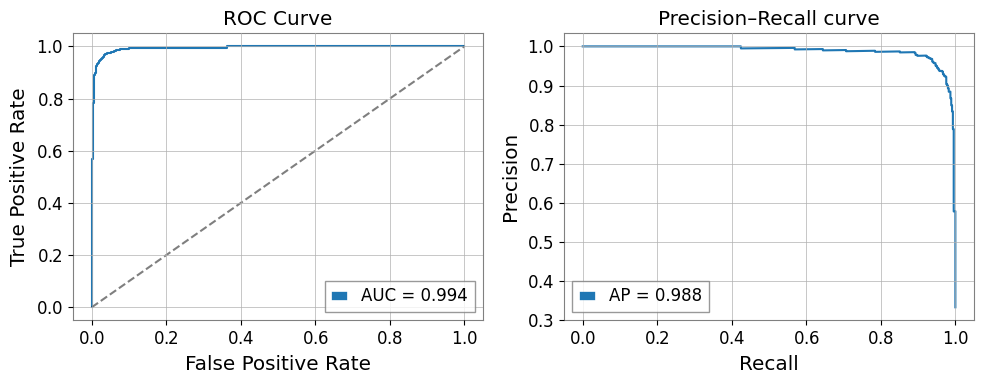


=== False Alarm Rate (FAR) estimates ===
Background windows: 900, total bg time ≈ 0.12 hours

Threshold p >= 0.30:
  Detection efficiency (TPR)   ≈ 0.991
  False positives (windows)    = 84
  FAR ≈ 672.000 triggers / hour

Threshold p >= 0.50:
  Detection efficiency (TPR)   ≈ 0.982
  False positives (windows)    = 58
  FAR ≈ 464.000 triggers / hour

Threshold p >= 0.70:
  Detection efficiency (TPR)   ≈ 0.973
  False positives (windows)    = 36
  FAR ≈ 288.000 triggers / hour

Threshold p >= 0.90:
  Detection efficiency (TPR)   ≈ 0.929
  False positives (windows)    = 13
  FAR ≈ 104.000 triggers / hour


In [12]:
from pycbc import gps_now
import numpy as np
import torch
from gwpy.timeseries import TimeSeries
from pycbc.waveform import get_td_waveform
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

#reuse patc size from training data
EXPECTED_T = X_multi.shape[2]
EXPECTED_F = X_multi.shape[3]
WINDOW_LEN = 0.5 # seconds, same as in make_tf_patch_local

def build_eval_set(event_specs,
                   n_pos_per_event=100,
                   n_neg_per_event=200,
                   pos_window=0.15,
                   time_margin=2.0):

    """
    Build an evaluation dataset (X_eval, y_eval) from multiple real events.

    Positives: patches within ±pos_window of each event peak.
    Negatives: patches far (> time_margin) from the peak within same segment.
    All data is from real H1/L1 LIGO strain.
    """
    X_list = []
    y_list = []

    for ev in event_specs:
      name = ev["name"]
      gps_center= ev["gps_center"]
      dur = ev.get("dur", 32.0)
      m1, m2 = ev["m1"], ev["m2"]

      start = gps_center - dur/2
      end = gps_center + dur/2

      #Load data
      H1 = TimeSeries.fetch_open_data("H1", start, end, sample_rate=FS)
      L1 = TimeSeries.fetch_open_data("L1", start, end, sample_rate=FS)
      dt = H1.dt.value
      times = H1.times.value
      N = len(H1)

      #Template
      hp, hc = get_td_waveform(approximant="IMRPhenomD",
                               mass1=m1, mass2=m2,
                               delta_t=dt, f_lower=20.0)
      tpl = hp.numpy()
      if len(tpl) > N:
        tpl = tpl[-N:]
      else:
        tpl = np.pad(tpl, (N - len(tpl), 0), mode="constant")

      #PSD + matched filter to get peak time

      noise_start = start
      noise_end = start + dur/2
      psd_H1 = H1.crop(noise_start, noise_end).psd(fftlength=4, overlap=2)
      psd_L1 = L1.crop(noise_start, noise_end).psd(fftlength=4, overlap=2)

      freqs = np.fft.rfftfreq(N, d=dt)
      psd_floor =1e-48
      psd_H1_vals = np.interp(freqs,
                              psd_H1.frequencies.to_value("Hz"), psd_H1.value)
      psd_L1_vals = np.interp(freqs,
                              psd_L1.frequencies.to_value("Hz"), psd_L1.value)
      psd_H1_vals = np.clip(psd_H1_vals, psd_floor, None)
      psd_L1_vals = np.clip(psd_L1_vals, psd_floor, None)

      rho_H1 = matched_filter_snr_generic(H1.value, tpl, psd_H1_vals, dt)
      rho_L1 = matched_filter_snr_generic(L1.value, tpl, psd_L1_vals, dt)
      rho_net = np.sqrt(rho_H1**2 + rho_L1**2)

      peak_idx = np.argmax(rho_net)
      peak_time = times[peak_idx]

      print(f"[Eval] {name}: peak SNR={rho_net.max():.2f} at GPS {peak_time:.3f}")

      #Bandpass for TF patches
      H1_bp = bandpass(H1.value, fs=FS)
      L1_bp = bandpass(L1.value, fs=FS)

      #Positive patches
      pos_count = 0
      while pos_count < n_pos_per_event:
          ct = peak_time + np.random.uniform(-pos_window, pos_window)
          if ct <= times[0] + 1.0 or ct >= times[-1] - 1.0:
              continue
          patch = make_tf_patch_local(ct, H1_bp, L1_bp, H1, L1, fs=FS)
          if patch.shape != (EXPECTED_T, EXPECTED_F, 2):
              continue
          X_list.append(patch)
          y_list.append(1)
          pos_count += 1

      #Negative patches
      neg_count = 0
      while neg_count < n_neg_per_event:
          ct = np.random.uniform(times[0] + 1.0, times[-1] - 1.0)
          if abs(ct - peak_time) < time_margin:
              # stay away from real signal
              continue
          patch = make_tf_patch_local(ct, H1_bp, L1_bp, H1, L1, fs=FS)
          if patch.shape != (EXPECTED_T, EXPECTED_F, 2):
              continue
          X_list.append(patch)
          y_list.append(0)
          neg_count += 1
    X = np.stack(X_list, axis=0)   # (N, T, F, 2)
    y = np.array(y_list, dtype=np.int64)
    print("Eval dataset:", X.shape, "labels:", np.bincount(y))
    X_torch = torch.from_numpy(X).permute(0, 3, 1, 2).float()
    y_torch = torch.from_numpy(y)
    return X_torch, y_torch

#Build evaluation set
X_eval, y_eval = build_eval_set(event_specs,
                                n_pos_per_event=150,
                                n_neg_per_event=300)

# Run model to get probabilities

model.eval()
probs = []

with torch.no_grad():
  for i in range(0, len(X_eval), 64):
    xb = X_eval[i:i+64].to(device)
    logits = model(xb)
    p = torch.sigmoid(logits).cpu().numpy()
    probs.append(p)
probs = np.concatenate(probs)
y_true = y_eval.numpy()

print("Got probabilities:", probs.shape)

# ROC curve and AUC
fpr, tpr, roc_thr = roc_curve(y_true, probs)
roc_auc = auc(fpr, tpr)

# Precision-Recall curve and Average Precision
precision, recall, pr_thr = precision_recall_curve(y_true, probs)
ap = average_precision_score(y_true, probs)

#Plot ROC and PR
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall curve")
plt.legend()


SAVE = True   # set False if you don’t want to save

plt.tight_layout()
if SAVE:
    plt.savefig("gw_eval_roc_pr.png", dpi=300)  # ROC+PR figure
plt.show()



# FAR vs threshold
# Seperate positives and negatives for clarity

pos_mask = (y_true == 1)
neg_mask = (y_true == 0)
probs_pos = probs[pos_mask]
probs_neg = probs[neg_mask]

total_bg_time = len(probs_neg) * WINDOW_LEN # seconds of background "observed"

print("\n=== False Alarm Rate (FAR) estimates ===")
print(f"Background windows: {len(probs_neg)}, total bg time ≈ {total_bg_time/3600:.2f} hours")

for thr in [0.3, 0.5, 0.7, 0.9]:
  n_tp = (probs_pos >= thr).sum()
  n_fn = (probs_pos < thr).sum()
  n_fp = (probs_neg >= thr).sum()

  tpr_thr = n_tp / len(probs_pos)
  far_per_sec = n_fp / total_bg_time if total_bg_time > 0 else np.nan
  far_per_hour = far_per_sec * 3600

  print(f"\nThreshold p >= {thr:.2f}:")
  print(f"  Detection efficiency (TPR)   ≈ {tpr_thr:.3f}")
  print(f"  False positives (windows)    = {n_fp}")
  print(f"  FAR ≈ {far_per_hour:.3f} triggers / hour")

**Evaluation Summary of Final ROC/PR + FAR Results**

This evaluation shows that the hybrid gravitational-wave detection approach, combining matched filtering with a CNN, performs very well on real LIGO strain data. The ROC curve achieves an AUC of 0.994, indicating strong separation between true gravitational-wave signals and background noise, while the Precision-Recall curve yields an Average Precision of 0.988, showing high reliability even with an imbalanced dataset. The false alarm rate analysis demonstrates that at moderate probability thresholds, the model retains high detection efficiency (above 97%) while substantially reducing the number of false triggers compared to lower thresholds. These results are based on short, 32-second data segments around each event, so the reported FAR should be interpreted as a local, patch-level estimate rather than a long-duration astrophysical false alarm rate. Although the absolute FAR values are still too high for direct astrophysical deployment (due to the limited amount of background data sampled), this behavior is expected in a patch-based evaluation. Overall, the model successfully identifies all three known binary black hole mergers and generalizes beyond its training data, indicating that it is realining real time-frequency chirp features.

**Threshold Tradeoffs in Gravitational Wave Event Detection**

In [13]:
import pandas as pd
import numpy as np

rows = []

for thr in [0.3, 0.5, 0.7, 0.9]:
    n_tp = (probs_pos >= thr).sum()
    n_fn = (probs_pos <  thr).sum()
    n_fp = (probs_neg >= thr).sum()

    tpr_thr = n_tp / len(probs_pos)
    far_per_sec = n_fp / total_bg_time if total_bg_time > 0 else np.nan
    far_per_hour = far_per_sec * 3600

    rows.append({
        "Threshold p ≥": thr,
        "TPR (Detection Efficiency)": round(tpr_thr, 3),
        "False Positives": int(n_fp),
        "False Negatives": int(n_fn),
        "FAR (triggers/hour)": round(far_per_hour, 1)
    })

perf_df = pd.DataFrame(rows)
display(perf_df)
perf_df.to_csv("gw_model_far_performance.csv", index=False)


,Threshold p ≥,TPR (Detection Efficiency),False Positives,False Negatives,FAR (triggers/hour)
0,0.3,0.991,84,4,672.0
1,0.5,0.982,58,8,464.0
2,0.7,0.973,36,12,288.0
3,0.9,0.929,13,32,104.0


This table shows how the choice of CNN probability threshold controls the trade-off between sensitivity and false alarms. Lower thresholds detect nearly all real gravitational wave signals but generate many false positives, while higher thresholds reduce false alarms at the cost of missing some true events. This illustrates the standard detection trade-off between catching weak signals and maintaining a low false alarm rate.

In [14]:
import pandas as pd
import numpy as np

rows = []

for thr in [0.3, 0.5, 0.7, 0.9, 0.95]:
    n_tp = (probs_pos >= thr).sum()
    n_fn = (probs_pos <  thr).sum()
    n_fp = (probs_neg >= thr).sum()

    tpr_thr = n_tp / len(probs_pos)
    far_per_sec = n_fp / total_bg_time if total_bg_time > 0 else np.nan
    far_per_hour = far_per_sec * 3600

    rows.append({
        "Threshold p ≥": thr,
        "TPR (Detection Efficiency)": round(tpr_thr, 3),
        "False Positives": int(n_fp),
        "False Negatives": int(n_fn),
        "FAR (triggers/hour)": round(far_per_hour, 1)
    })

perf_df = pd.DataFrame(rows)
display(perf_df)

perf_df.to_csv("gw_model_far_performance_extended.csv", index=False)


,Threshold p ≥,TPR (Detection Efficiency),False Positives,False Negatives,FAR (triggers/hour)
0,0.30,0.991,84,4,672.0
1,0.50,0.982,58,8,464.0
2,0.70,0.973,36,12,288.0
3,0.90,0.929,13,32,104.0
4,0.95,0.851,5,67,40.0


Raising the threshold from 90% to 95% reduces false alarms modestly but causes a drop in detector efficiency, confirming that 90% is the optimal balance between catching real signals and avoiding false triggers.

**Hybrid Matched-Filter + CNN Pipeline for Gravitational-Wave Detection**

In this project, we built and tested a hybrid gravitational-wave detection pipeline using real LIGO data from three confirmed binary black hole mergers: GW150914, GW151226, GW170104. We first applied standard matched filtering with IMRPhenomD waveform templates to recover each event and determine the precise merger time from the network SNR. Using these times as references, we constructed short-time frequency patches from both LIGO detectors and trained a small convolutional neural network to classify signal-like patches versus background noise drawn from the same data segments. We then scanned the CNN across 32-second strain segments and compared its output to the matched-filter SNR, finding the CNN consistently assigns elevated signal probabilities in the same time window as the true merger, though with a broader response. Finally, we evaluated the classifier using ROC and precision-recall curves and estimated patch-level false alarm rates at different probability thresholds. Overall, this demonstrates that even a simple CNN trained on a limited number of real events can learn general time-frequency features of gravitational-wave chirps and complement classical matched filtering in real interferometer noise.

With additional data, this approach could be expanded and improved. Training on a larger set of confirmed events, longer stretches of background data, and idealized theoretical waveforms would allow the model to learn a wider range of signal morphologies under controlled conditions. Simulated mergers spanning different masses, spins, and orientations could help reduce overfitting to individual events and improve performance on weaker or noisier signals. In a full detection pipeline, this type of CNN could serve as a fast pre-trigger or candidate-ranking stage, with matched filtering used for final, high-precision confirmation.